In [ ]:
# Cell 1: Setup - Configure kagglehub and import dependencies
# PURPOSE: Initialize the notebook environment with required libraries

import os         # OS utilities for file path management
import json       # JSON parsing for reading Kaggle credentials
import pandas as pd  # Data manipulation library
import kagglehub  # Kaggle Hub API for dataset downloads
from PIL import Image  # Image processing library

In [2]:
# Cell 2: Download & Load Dataset
# PURPOSE: Download the HCMC AQI traffic camera dataset from Kaggle
# DATASET: nghigia/hcmc-aqi-traffic-camera-dataset (~1GB)

# Download dataset
path = kagglehub.dataset_download("nghigia/hcmc-aqi-traffic-camera-dataset")
print(f"Dataset location: {path}")

# Navigate to data subdirectory
data_path = os.path.join(path, 'datasets')
if os.path.exists(data_path):
    path = data_path

100%|██████████| 1.02G/1.02G [02:17<00:00, 8.02MB/s]

Extracting files...


Dataset location: /Users/ianmorris/.cache/kagglehub/datasets/nghigia/hcmc-aqi-traffic-camera-dataset/versions/1


In [3]:
# Cell 3: Verify Files Downloaded
# PURPOSE: View the directory structure to confirm dataset was downloaded correctly

for root, dirs, filenames in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in filenames[:10]:
        print(f'{subindent}{file}')

datasets/
  camera_infomation.csv
  NVL_HTP2/
    19-10-2025-17-58-30.json
    19-10-2025-00-20-14.json
    20-10-2025-05-38-07.json
    19-10-2025-13-34-47.json
    19-10-2025-00-56-41.json
    20-10-2025-03-23-51.png
    20-10-2025-01-45-36.png
    20-10-2025-05-48-26.png
    20-10-2025-12-10-53.png
    20-10-2025-07-26-19.png
  QL1_TL10B/
    19-10-2025-17-17-09.png
    20-10-2025-08-54-15.json
    19-10-2025-12-42-56.json
    20-10-2025-12-21-25.json
    19-10-2025-23-57-20.json
    19-10-2025-00-41-12.json
    20-10-2025-01-40-33.json
    19-10-2025-13-55-40.png
    20-10-2025-05-02-04.json
    20-10-2025-10-58-40.png
  TL43_KCXLT2/
    19-10-2025-12-27-13.json
    20-10-2025-11-40-00.json
    20-10-2025-01-35-21.json
    19-10-2025-23-00-10.json
    20-10-2025-07-52-15.png
    19-10-2025-17-43-01.json
    19-10-2025-21-04-34.json
    19-10-2025-15-03-13.json
    18-10-2025-23-59-16.json
    20-10-2025-06-14-18.json
  VX_MT2/
    20-10-2025-00-12-51.png
    19-10-2025-18-51-00.jso

# Answer only these questions (don’t model yet):

## 1️⃣ What does each folder represent?

Is it a single camera?

A location?

A time span?

Check:

Number of images per folder

Timestamps (from filenames or JSON)

Resolution consistency


In [7]:
# PURPOSE: Understand folder organization (camera vs location vs time span)
# CHECK: Number of images per folder, timestamps, resolution consistency

# Get top-level folders
top_folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
print(f"Number of top-level folders: {len(top_folders)}\n")

Number of top-level folders: 16



In [8]:

# Analyze each folder
folder_stats = {}
for folder in sorted(top_folders)[:5]:  # Limit to first 5 folders for quick analysis
    folder_path = os.path.join(path, folder)
    
    # Count images
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_images = len(image_files)
    
    # Get image resolutions
    resolutions = set()
    for img_file in image_files[:3]:  # Check first 3 images
        try:
            img = Image.open(os.path.join(folder_path, img_file))
            resolutions.add(img.size)
        except:
            pass
    
    # Check for metadata files
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    
    # Check filenames for timestamps
    timestamps = []
    for img_file in image_files[:5]:
        if any(char.isdigit() for char in img_file):
            timestamps.append(img_file)
    
    folder_stats[folder] = {
        'num_images': num_images,
        'resolutions': resolutions,
        'json_files': json_files,
        'sample_filenames': image_files[:3],
        'has_timestamps': len(timestamps) > 0
    }

# Display summary
for folder, stats in folder_stats.items():
    print(f"Folder: {folder}")
    print(f"  - Images: {stats['num_images']}")
    print(f"  - Resolutions: {stats['resolutions']}")
    print(f"  - JSON metadata: {len(stats['json_files'])} file(s)")
    print(f"  - Has timestamps: {stats['has_timestamps']}")
    print(f"  - Sample files: {stats['sample_filenames']}")
    print()

Folder: LXO_CTL
  - Images: 310
  - Resolutions: {(284, 177), (512, 288)}
  - JSON metadata: 310 file(s)
  - Has timestamps: True
  - Sample files: ['20-10-2025-03-18-38.png', '20-10-2025-03-59-58.png', '19-10-2025-12-16-46.png']

Folder: LXO_D2
  - Images: 310
  - Resolutions: {(512, 288)}
  - JSON metadata: 310 file(s)
  - Has timestamps: True
  - Sample files: ['19-10-2025-11-40-22.png', '18-10-2025-23-59-06.png', '19-10-2025-21-14-51.png']

Folder: LXO_LL
  - Images: 310
  - Resolutions: {(512, 288)}
  - JSON metadata: 310 file(s)
  - Has timestamps: True
  - Sample files: ['20-10-2025-00-12-45.png', '19-10-2025-15-29-07.png', '20-10-2025-07-05-39.png']

Folder: NTD_C
  - Images: 310
  - Resolutions: {(512, 288)}
  - JSON metadata: 310 file(s)
  - Has timestamps: True
  - Sample files: ['20-10-2025-00-12-51.png', '19-10-2025-00-30-45.png', '20-10-2025-11-29-37.png']

Folder: NTD_CACCCL
  - Images: 310
  - Resolutions: {(512, 288)}
  - JSON metadata: 310 file(s)
  - Has timestamps: 

PNG that are unusable for modeling (e.g., corrupted files) are 3KB or smaller. These should be removed from the dataset before modeling.


## 2️⃣ Are there obvious failure frames?

Manually inspect:

Black frames

Extreme blur

Obstruction

Overexposure

Frozen scenes

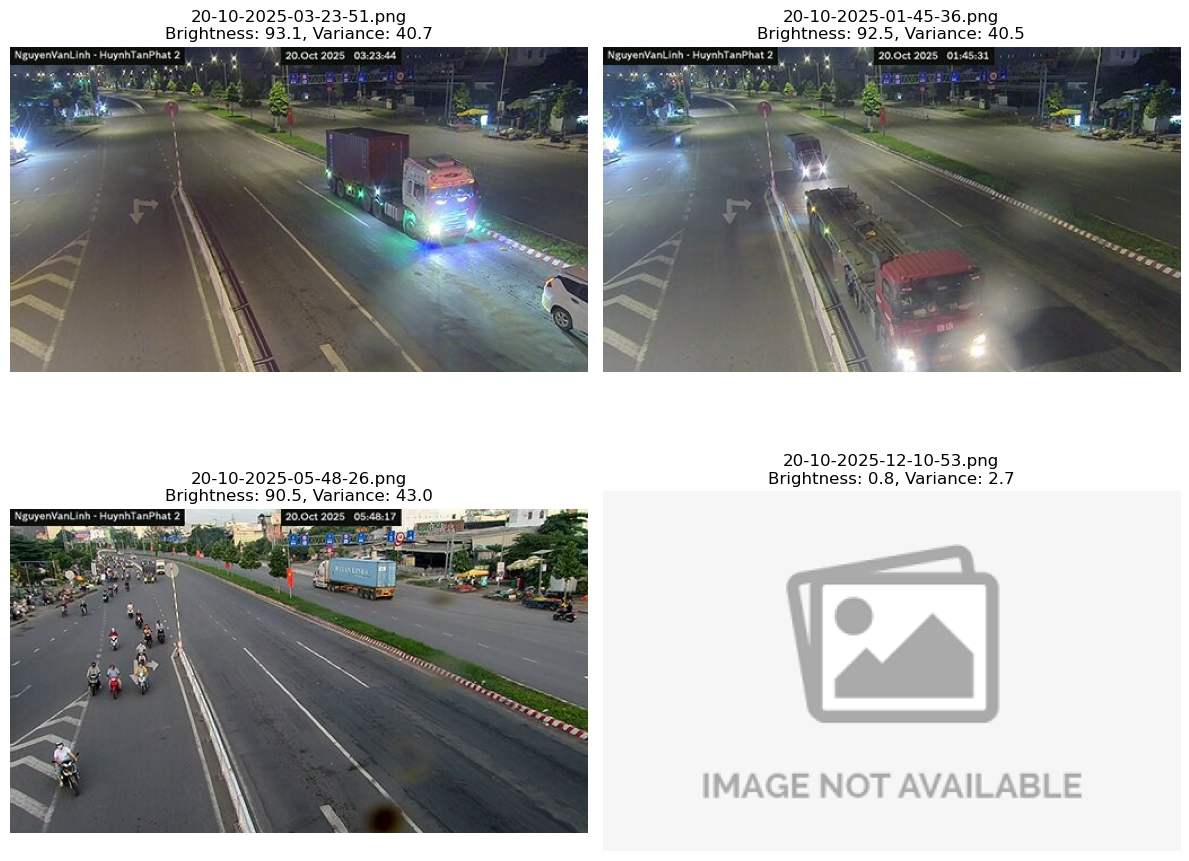

Visual inspection notes:
- BLACK/DARK frames: Brightness < 50
- OVEREXPOSED: Brightness > 200
- BLUR/OBSTRUCTION: Low variance (std_dev < 30)
- Frozen scenes: Identical consecutive frames
- Misalignment: Check for partial black bars or skewing


In [5]:
# PURPOSE: Analyze images for failure modes (blur, obstruction, overexposure, darkness, frozen frames)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Get sample images from first folder
sample_folder = top_folders[0]
sample_path = os.path.join(path, sample_folder)
image_files = [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:4]

# Display sample images with analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, img_file in enumerate(image_files):
    img_path = os.path.join(sample_path, img_file)
    img = Image.open(img_path)
    img_array = np.array(img)
    
    # Calculate basic statistics
    brightness = np.mean(img_array)
    std_dev = np.std(img_array)  # High std = detail, Low std = blur/obstruction
    
    # Display image
    axes[idx].imshow(img)
    axes[idx].set_title(f"{img_file}\nBrightness: {brightness:.1f}, Variance: {std_dev:.1f}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Visual inspection notes:")
print("- BLACK/DARK frames: Brightness < 50")
print("- OVEREXPOSED: Brightness > 200")
print("- BLUR/OBSTRUCTION: Low variance (std_dev < 30)")
print("- Frozen scenes: Identical consecutive frames")
print("- Misalignment: Check for partial black bars or skewing")

In [ ]:
# Cell 10: Identify and Remove Corrupted Images
# PURPOSE: Find and remove PNG files that are 3KB or smaller (corrupted/unusable)
# THRESHOLD: 3KB (3072 bytes) - files below this are considered corrupted

# Find all PNG files and check file sizes
corrupted_files = []
total_size_removed = 0
corrupted_count = 0

# Walk through all image folders
for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    
    if os.path.isdir(folder_path):
        # Check each PNG file in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                filepath = os.path.join(folder_path, filename)
                file_size = os.path.getsize(filepath)
                
                # Check if file is corrupted (3KB or smaller)
                if file_size <= 3072:  # 3KB in bytes
                    corrupted_files.append({
                        'path': filepath,
                        'folder': folder_name,
                        'filename': filename,
                        'size': file_size
                    })
                    corrupted_count += 1
                    total_size_removed += file_size

# Display results
print(f"Corrupted Images Found: {corrupted_count}")
print(f"Total Size of Corrupted Files: {total_size_removed / 1024:.2f} KB\n")

if corrupted_files:
    print("Corrupted files by folder:")
    folder_corruption = {}
    for file_info in corrupted_files:
        folder = file_info['folder']
        if folder not in folder_corruption:
            folder_corruption[folder] = 0
        folder_corruption[folder] += 1
    
    for folder, count in sorted(folder_corruption.items()):
        print(f"  {folder}: {count} corrupted files")
    
    # Ask if you want to remove them (optional)
    print("\nTo remove corrupted files, uncomment and run the code below:")
    for file_info in corrupted_files:
        os.remove(file_info['path'])
    print(f"Removed: {file_info['folder']}/{file_info['filename']}")
else:
    print("No corrupted files found!")

Corrupted Images Found: 0
Total Size of Corrupted Files: 0.00 KB

No corrupted files found!


## Search for Frozen Frames

In [27]:
def hash_file(filepath):
    """Calculate the MD5 hash of a file"""
    hasher = hashlib.md5()
    try:
        with open(filepath, 'rb') as f:
            while chunk := f.read(8192):
                hasher.update(chunk)
    except Exception as e:
        print(f"Error hashing file {filepath}: {e}")
        return None
    return hasher.hexdigest()

def find_exact_duplicates(directory):
    """Finds exact duplicate files in a directory."""
    hashes = defaultdict(list)
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            # Optional optimization: check file sizes first
            if os.path.getsize(filepath) > 0:
                file_hash = hash_file(filepath)
                if file_hash:
                    hashes[file_hash].append(filepath)

    return {h: paths for h, paths in hashes.items() if len(paths) > 1}


In [28]:

# Scan each folder for exact duplicates (frozen frames)
all_duplicates = {}

for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    
    if os.path.isdir(folder_path):
        duplicate_files = find_exact_duplicates(folder_path)
        if duplicate_files:
            all_duplicates[folder_name] = duplicate_files

# Print the results
if all_duplicates:
    print("Exact duplicate files (frozen frames) found:\n")
    for folder_name, duplicate_files in all_duplicates.items():
        print(f"📁 {folder_name}:")
        for file_hash, file_paths in duplicate_files.items():
            print(f"  Hash: {file_hash} ({len(file_paths)} copies)")
            for path in file_paths:
                print(f"    - {os.path.basename(path)}")
        print()
else:
    print("✓ No exact duplicate files (frozen frames) found in any folder!")

Exact duplicate files (frozen frames) found:

📁 NVL_HTP2:
  Hash: 71fe64b9634d3e678b7614a1e8e39cc2 (2 copies)
    - 19-10-2025-17-58-30.json
    - 19-10-2025-17-53-19.json
  Hash: 1e8c1808290dda9de34d5472cfeb9b3c (2 copies)
    - 20-10-2025-05-38-07.json
    - 20-10-2025-05-43-16.json
  Hash: 490aaa831e03727691a2b08d49a09b43 (2 copies)
    - 20-10-2025-07-41-47.json
    - 20-10-2025-07-36-39.json
  Hash: 45878af1100650f80f0f8cb8fef702cf (2 copies)
    - 19-10-2025-22-44-35.json
    - 19-10-2025-22-49-44.json
  Hash: 21524bc56481d7988fe046d370312d19 (2 copies)
    - 20-10-2025-11-08-54.json
    - 20-10-2025-11-03-44.json
  Hash: d9b0f2f1ca13fdba210b40555fb43639 (2 copies)
    - 20-10-2025-05-07-07.json
    - 20-10-2025-05-01-58.json
  Hash: 2f0c3c61d670e2913c7b18ed4d64fe63 (2 copies)
    - 20-10-2025-12-05-43.json
    - 20-10-2025-12-10-53.json
  Hash: 9110c02d797d8a3e38b35703652c1392 (2 copies)
    - 19-10-2025-01-53-47.json
    - 19-10-2025-01-58-56.json
  Hash: 556b75f6f4bb1605281000